<a href="https://colab.research.google.com/github/ivanadu/school-zoning/blob/main/school_zoning_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Important Notes

**Purpose**

My purpose of this project is to examine implementing an optimization model. During this problem set, I will also look at implementing and interpreting data analysis related to equitable education policies.

I will be using data presented in the paper below:

https://www.uts.edu.au/sites/default/files/2022-06/SFUSD_Policy_Paper_Draft.pdf



In [ ]:
# testing if GPU is enabled
# should output `/device:GPU:0`
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Loading packages needed
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

# mount drive and add to path
drive.mount('/content/drive')

# importing custom module
from importlib.machinery import SourceFileLoader
module = SourceFileLoader("assignment", "/content/drive/My Drive/data_analysis/school_zoning/assignment.py").load_module()
from assignment import SchoolAssigner

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Choosing which data to use

In this part, I explore some of the challenges of deciding which data to use, especially when the datasets are small and exact measurement is not always possible. I will do this in the context of the San Francisco Unified School District (SFUSD) school choice redesign project.

The redesign had three primary goals:
- **Diversity:** schools should be socioeconomically and racially representative of the district as a whole.
- **Proximity:** students should be able to go to school close to home.
- **Predictability**: families should have a right to predictability, simplicity, and transparency as they go through the student assignment system.

Considering the goal of socioeconomic status, the following measures are available:

freelunch_prob, reducedlunch_prob, median_hh_income, ethinicity_desc, resolved_ethinicity

An explanation of data usage:

By using aggregate data rather than individual, it makes the use more ethical by protecting user data. This way, privacy is maintained and making individual information difficult to identify, possible response bias is reduced through maintained anonymity. This format of data also make it more comprehensible by significantly reducing the data of a given demographic from complex datasets to values that are easier to be understood and interpreted. This is especially important when communicating data to other researchers or the general public.

Aggregate data is also useful for revealing trends and patterns. By interpreting individual data points, it is easy to misinterpret data and draw false conclusions, but aggregate data allows for a more hollistic view to make more objective and informed decisions.

On the other hand, there are also many drawbacks to using aggregate data, such as the loss of individual responses. Given that something we would like to preserve is school choice, something based completely off of personal preference, the generalization of groups into aggregate data could give a false impression of how beneficial each policy is. Additionally, aggregate data may lead to the obstruction of biases and risks misinterpretation when the data is overgeneralized. Thus aggregate data must be used with caution.

When considering the possible measures of socioeconomic status, I think the most accurate would be the 'freelunch_prob' and 'reducedlunch_prob' data. This is because it helps to describe the socioeconomic status of a group of students in a way that is easier to interpret. The benchmarks for free and reduced lunch are sufficient when evaluating socioeconomic status for this scenario while median_hh_income would provide too much data to be efficiently analyzed. Data for median_hh_income also could be misleading due to special familial circumstances whereas it is likely already accounted for in free and reduced lunch data. 'ethnicity_desc' and 'resolved_ethinicty' also would not make the best measure as though they are often considered measures of socioeconomic status, they give no clear ordinal or quantitative data to be assessed. Ethinicity would also not be accurate for the school choice/policy scenario as though ethnicity is often correlated with income, it doesn't provide an accurate generalization as socioeconomic status still varies greatly among ethinicities.

Measures of location:

aa, aaprek, census_block, census_blockgroup, census_tract, latitude, longitude, zipcode

I would use 'census_blockgroup' as it is an appropriate size for assessing student proximity. By using a larger measure, we risk inaccurate values for student distances from a given school such as with census_block or census_tract. On the otehr hand, by using a measurement too small such as latitude and longitude, data mangement and interpretability will be difficult. Thus a measurement in between is ideal.

## Measuring trade-offs with multiple objectives

The district's objectives require trade-offs; for example, the proximity and diversity goals are often in opposition due to residential segregation. To understand this particular trade-off, we need to measure both the proximity and the racial and ethnic representativeness of the school assignments.

There are several ways to measure **diversity**. One metric, known as dissimilarity, measures the percentage of students from different socioeconomic or racial backgrounds that would need a different assignment for every school to be representative of the district. We can measure **distance** as the average distance between students and their assigned schools.

We can combine our distance and diversity objectives using a parameter $\lambda \in [0,1]$. Varying $\lambda$ allows us to pick how much we care about the two objectives relative to each other (e.g., $\lambda = 1$ implies we only care about distance, $\lambda = 0$ implies we only care about diversity).

$$
\text{min} \quad \lambda \text{OBJ}_{dist} + (1-\lambda)\text{OBJ}_{div}
$$

I have implemented this weighted objective in a custom class called `SchoolAssigner`.

In [ ]:
#EXAMPLE USAGE

#instantiate SchoolAssigner using input data
assigner = SchoolAssigner('/content/drive/My Drive/data_analysis/school_zoning/opt_inputs.pickle')

assigner.assign_students(0.1)

print((assigner.distance, assigner.diversity))

Optimizing assignment for lambda = 0.1...
Solution converged in 3.09 seconds
(1.2226931513180441, 0.00015365520898508666)


Using 10 evenly spaced values between 0 and 1 for lambda, I will use `SchoolAssigner` to compute the two objectives for each value of $\lambda$.

In [ ]:
#Compute objectives at different values of lambda
#For each objective, store the value in a list for each value of lambda

vals = np.linspace(0, 1, 10)
distance = []
diversity = []

for val in vals:
  assigner.assign_students(val)
  distance.append(assigner.distance)
  diversity.append(assigner.diversity)

data = {'lambda': vals,
        'Distance Objective': distance,
        'Diversity Objective': diversity}
df = pd.DataFrame(data)

df

Optimizing assignment for lambda = 0.0...
Solution converged in 1.64 seconds
Optimizing assignment for lambda = 0.11...
Solution converged in 3.11 seconds
Optimizing assignment for lambda = 0.22...
Solution converged in 5.22 seconds
Optimizing assignment for lambda = 0.33...
Solution converged in 5.94 seconds
Optimizing assignment for lambda = 0.44...
Solution converged in 16.36 seconds
Optimizing assignment for lambda = 0.56...
Solution converged in 16.90 seconds
Optimizing assignment for lambda = 0.67...
Solution converged in 7.94 seconds
Optimizing assignment for lambda = 0.78...
Solution converged in 8.28 seconds
Optimizing assignment for lambda = 0.89...
Solution converged in 7.66 seconds
Optimizing assignment for lambda = 1.0...
Solution converged in 4.84 seconds


,lambda,Distance Objective,Diversity Objective
0,0.000000,1.500000,0.000009
1,0.111111,1.222672,0.000154
2,0.222222,1.193957,0.018812
3,0.333333,1.042057,0.140728
4,0.444444,1.010938,0.181960
5,0.555556,0.975621,0.233381
6,0.666667,0.959401,0.320767
7,0.777778,0.926058,0.445475
8,0.888889,0.880585,0.496928
9,1.000000,0.894820,0.604616


Plotting the trade-off curve with $OBJ_{dist}$ on the x-axis and $OBJ_{div}$ on the y-axis.  

<Axes: xlabel='Distance Objective', ylabel='Diversity Objective'>

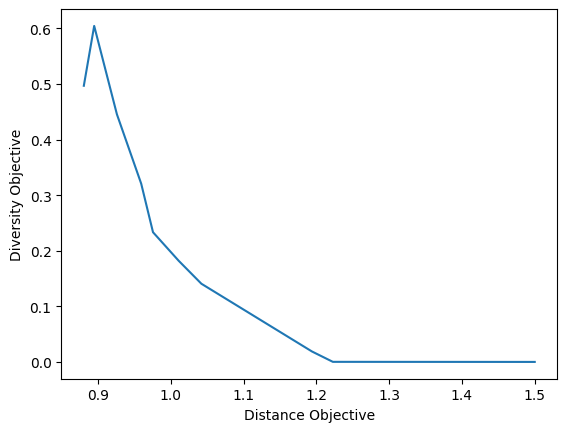

In [ ]:
#plot the tradeoff curve

sns.lineplot(df, x='Distance Objective', y='Diversity Objective')

#Part 3: Evaluating assignment policies

In the actual school choice redesign, several objectives were computed for four possible assignment policies:

- **Zones:** Families are restricted to choose programs at schools in medium-sized zones around their home.
- **Zones + Reserves**: Families are restricted to choose programs at schools in medium-sized zones around their home, with seats held in reserve to achieve diversity goals.
- **Priorities:** Priority is given to certain underserved groups (e.g., lowest test scores).
- **2018-2019 Assignment:** Results of actual district-wide choice in 2018-19, guided by 58 contiguous 'attendance areas' that serve as the neighborhood for one school, with a priority and lottery system to assign students to over-demanded schools.

In this part, I will evaluate the four assignment policies on a variety of performance metrics related to the redesign goals.

In [ ]:
#Read in table 2 data from the paper
table2 = pd.read_csv('/content/drive/My Drive/data_analysis/school_zoning/table2.csv')

# inspect first few rows
table2.head()

,Policy,Metric,Value
0,Zones,Avg. Distance,1.35
1,Zones + Reserves,Avg. Distance,1.29
2,Priorities,Avg. Distance,1.91
3,2018-2019,Avg. Distance,1.39
4,Zones,Distance <= 0.5,0.30


A barplot may be made using any one of the following metrics:

- Distance $\leq 0.5$ miles: Percentage of students within a walking distance of 0.5 miles.
- Distance $\geq 3$ miles: Percentage of students assigned further than 3 miles from home.
- +15% FRL Schools: Percentage of schools where the FRL average of students assigned to the school is greater than 15% above the fraction of students eligible for FRL district-wide.
-Rank Top 1: Number of students receiving their top choice.

I will focus on Rank Top 1.

[Text(0.5, 0, ''), Text(0, 0.5, 'Rank Top 1')]

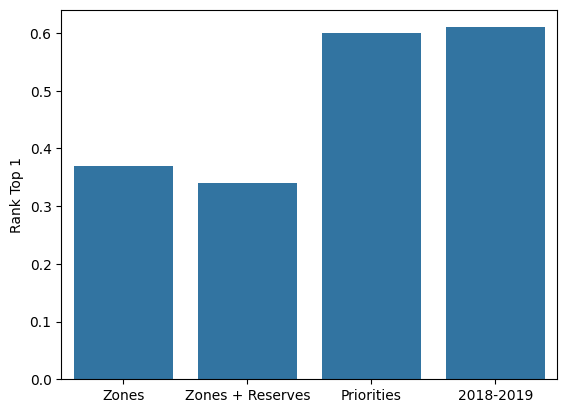

In [ ]:
plot_data = table2.loc[(table2.Metric == 'Rank Top 1'),]

#Template for bar plot using average distance metric
fig, ax = plt.subplots()
sns.barplot(data = plot_data, x = 'Policy', y = 'Value',
            dodge = False, ax = ax)
ax.set(xlabel = '', ylabel = 'Rank Top 1')

According to the 'Rank Top 1' metric, the 2018-2019 policy performed the best with a value of about 0.6. This means that out of all students, ~60% got their first choice school. This likely means that the 2018-2019 policy prioritized student choice. The 'Zones + Reserves' metric performed the worst with a value around 0.35. This low score is  due to the lack of choice that is presented with zones which are only based off geographical location. This doesn't allow for many students to attend a school other than the one they live nearby. The reserves additionally reduced the 'Rank Top 1' metric as in an attempt to increase diversity, students are more likely to be assigned to a school which is not their top choice or their top choice will not have space for them.

I also want to perform evaluations by race and ethnicity. Each row of the table 3 data represents an evaluation metric (specified in the `Metric` column) associated with each assignment policy (specified in the `Policy` column), split by ethnicity (specified in the `Group` column).


In [ ]:
# Read in table 3 data
table3 = pd.read_csv('/content/drive/My Drive/data_analysis/school_zoning/table3.csv')

# inspect first few rows
table3.head()

,Policy,Group,Metric,Value
0,Zones,African American,Avg. Distance,1.45
1,Zones + Reserves,African American,Avg. Distance,1.27
2,Priorities,African American,Avg. Distance,2.24
3,2018-2019,African American,Avg. Distance,1.82
4,Zones,Asian,Avg. Distance,1.43


Barplot can be made using the metrics from the following list:

- In + 15% FRL: Percentage of schools where the FRL average of students assigned to the school is greater than 15% above the fraction of students eligible for FRL district-wide.
- Dist >= 3, Rank >=5: Percentage of students assigned at least 3 miles away from their home to a program they ranked 5th or higher.

I will use In + 15% FRL

[Text(0.5, 0, ''), Text(0, 0.5, 'In +15% FRL')]

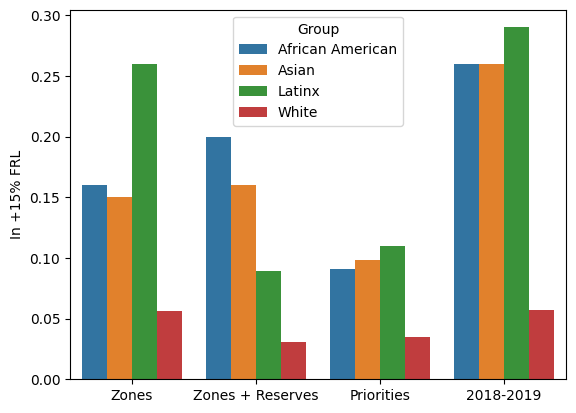

In [ ]:
# Select metric
plot_data = table3.loc[(table3.Metric == 'In +15% FRL'),]

# bar plot using average distance metric
fig, ax = plt.subplots()
sns.barplot(data = plot_data, x = 'Policy', y = 'Value', hue = 'Group')
ax.set(xlabel = '', ylabel = 'In +15% FRL')

In the plot, a high value of the 'In +15% FRL' metric is ideal as it means that underprivileged groups that would usually be underrepresented in more privileged schools are successfully able to attend these schools due to the implemented policy. This means that a higher value means more advantage for a given policy and ethinicty. It can be seen that minority groups experience greatly differing amount of advantage depending on the implemented policy. The Latinx students are greatly advantaged by the 'Zones' policy, likely meaning that there is a large amount of low-income Latinx families relative to the total amount of Latinx families. However it can be seen that they are greatly disadvantaged in the 'Zones + Reserves' policy as it can be seen that the reserves were more targeted towards African American and Asian students who experienced higher measures of the 'In +15% FRL' metric. The 'Priorities' policy appears to disadvantage all minorities. The low measures across all policies for the white students is likely not due disadvantage, but due to the fact that white students in America are generally more well off than their African American/Asian/Latinx counterparts. However it can still be seen that they are disadvantaged by the 'Zones + Reserves' policy. Overall, the '2018-2019' policy seems the best, allowing for ethnic and socioeconomic diversity while not disadvantaging one group over another.